In [2]:
# Basic stuff
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# time series
from prophet import *

In [2]:
db_name = 'capstone'
db_host = 'localhost'
db_user = 'root'
db_password = 'rootroot'

connection = pymysql.connect(host=db_host,
                             user=db_user,
                             password=db_password,
                             db=db_name)

In [3]:
cursor = connection.cursor()

# Read data from the MySQL database into a Pandas DataFrame
df = pd.read_sql('SELECT attendance, hteam, vteam, park_id, hleague, day, daynight, player_weights, player_heights, player_bats, player_throws, vscore, '+
                 'len_game, h_pch_used, h_errors, v_walks, len_min, v_sf, v_lft_base, h_errors, h_assists '+
                 'FROM gm_logs', connection)

# Close the cursor and connection
cursor.close()
connection.close()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210012 entries, 0 to 210011
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   attendance      203255 non-null  float64
 1   hteam           210012 non-null  object 
 2   vteam           210012 non-null  object 
 3   park_id         210012 non-null  object 
 4   hleague         210012 non-null  object 
 5   day             210012 non-null  object 
 6   daynight        210012 non-null  object 
 7   player_weights  210012 non-null  object 
 8   player_heights  210012 non-null  object 
 9   player_bats     210012 non-null  object 
 10  player_throws   210012 non-null  object 
 11  vscore          210012 non-null  int64  
 12  len_game        210012 non-null  int64  
 13  h_pch_used      210012 non-null  int64  
 14  h_errors        210012 non-null  int64  
 15  v_walks         210012 non-null  int64  
 16  len_min         207136 non-null  float64
 17  v_sf      

In [5]:
df.isna().sum()

attendance        6757
hteam                0
vteam                0
park_id              0
hleague              0
day                  0
daynight             0
player_weights       0
player_heights       0
player_bats          0
player_throws        0
vscore               0
len_game             0
h_pch_used           0
h_errors             0
v_walks              0
len_min           2876
v_sf                 0
v_lft_base           0
h_errors             0
h_assists            0
dtype: int64

In [6]:
# Fill NaN values in 'attendance' column with median and convert to int
df['attendance'] = df['attendance'].fillna(df['attendance'].median()).astype(int)

df['len_min'].fillna(method='ffill', inplace=True)

# Print DataFrame info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210012 entries, 0 to 210011
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   attendance      210012 non-null  int32  
 1   hteam           210012 non-null  object 
 2   vteam           210012 non-null  object 
 3   park_id         210012 non-null  object 
 4   hleague         210012 non-null  object 
 5   day             210012 non-null  object 
 6   daynight        210012 non-null  object 
 7   player_weights  210012 non-null  object 
 8   player_heights  210012 non-null  object 
 9   player_bats     210012 non-null  object 
 10  player_throws   210012 non-null  object 
 11  vscore          210012 non-null  int64  
 12  len_game        210012 non-null  int64  
 13  h_pch_used      210012 non-null  int64  
 14  h_errors        210012 non-null  int64  
 15  v_walks         210012 non-null  int64  
 16  len_min         210012 non-null  float64
 17  v_sf      

In [7]:
df.head()

,attendance,hteam,vteam,park_id,hleague,day,daynight,player_weights,player_heights,player_bats,...,vscore,len_game,h_pch_used,h_errors,v_walks,len_min,v_sf,v_lft_base,h_errors,h_assists
0,0,WS1,BOS,WAS07,AL,Sat,D,"178,165,190,162,169,000,000,000,000","175,178,188,173,175,000,000,000,000","R,R,L,R,L,B,R,L,R",...,3,60,1,0,3,110.0,-1,6,0,15
1,4593,PHI,BRO,PHI09,NL,Thu,D,"180,170,170,190,140,000,000,000,000","175,170,178,180,163,000,000,000,000","R,B,L,B,L,R,B,R,L",...,12,54,2,1,3,125.0,-1,6,1,13
2,0,PIT,SLN,PIT05,NL,Sat,D,"162,170,160,167,160,000,000,000,000","178,178,170,168,178,000,000,000,000","R,R,R,L,R,R,,R,L",...,2,51,1,0,1,125.0,-1,5,0,13
3,8061,PIT,SLN,PIT05,NL,Sat,D,"162,170,160,167,160,000,000,000,000","178,178,170,168,178,000,000,000,000","R,R,R,L,R,R,R,R,L",...,2,51,1,0,2,125.0,-1,5,0,10
4,3000,BOS,DET,BOS07,AL,Thu,D,"140,175,190,168,175,000,000,000,000","168,185,183,178,180,000,000,000,000","B,L,L,R,R,L,L,L,R",...,15,54,3,5,5,120.0,0,11,5,17


In [8]:
# Create new columns with conditional logic for handling nulls
df["count_L_bats"] = df["player_bats"].fillna("").str.count("L")
df["count_L_throws"] = df["player_throws"].fillna("").str.count("L")

# Ensure the new columns have integer data types
df["count_L_bats"] = df["count_L_bats"].astype("int")
df["count_L_throws"] = df["count_L_throws"].astype("int")

In [9]:
# Function to handle object type 'player_weights' with NaNs, calculate median (int)
def process_weights(weight_str):
  # Check if it's a string
  if not isinstance(weight_str, str):
    return 0  # Handle non-string cases (e.g., return 0)
  
  # Extract weights (assuming comma-separated) and handle NaNs
  try:
    weights = [int(w.replace(',', '')) if not pd.isna(w) else 0 for w in weight_str.split(',')]
  except ValueError:
    # Handle potential conversion errors (e.g., non-numeric values in the string)
    return 0  # Or return another default value
  
  # Calculate and return median as int
  return int(pd.Series(weights).median())

In [10]:
# Create a new column with processed median
df['median_weights'] = df['player_weights'].apply(process_weights)
df['median_heights'] = df['player_heights'].apply(process_weights)

# Fill NaN values in 'attendance' column with median and convert to int
df['attendance'] = df['attendance'].astype(int)
df['median_weights'] = df['median_weights'].astype(int)
df['median_heights'] = df['median_heights'].astype(int)

# Replace 0s in 'median_weights' with the median of the entire column (consider other imputation strategies if needed)
df['median_weights'] = df['median_weights'].replace(0, df['median_weights'].median())
df['median_heights'] = df['median_heights'].replace(0, df['median_heights'].median())
df['attendance'] = df['attendance'].replace(0, df['attendance'].median())

# Print info
print(df.info())  # Print only the first few lines

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210012 entries, 0 to 210011
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   attendance      210012 non-null  int32  
 1   hteam           210012 non-null  object 
 2   vteam           210012 non-null  object 
 3   park_id         210012 non-null  object 
 4   hleague         210012 non-null  object 
 5   day             210012 non-null  object 
 6   daynight        210012 non-null  object 
 7   player_weights  210012 non-null  object 
 8   player_heights  210012 non-null  object 
 9   player_bats     210012 non-null  object 
 10  player_throws   210012 non-null  object 
 11  vscore          210012 non-null  int64  
 12  len_game        210012 non-null  int64  
 13  h_pch_used      210012 non-null  int64  
 14  h_errors        210012 non-null  int64  
 15  v_walks         210012 non-null  int64  
 16  len_min         210012 non-null  float64
 17  v_sf      

In [11]:
df.head()

,attendance,hteam,vteam,park_id,hleague,day,daynight,player_weights,player_heights,player_bats,...,v_walks,len_min,v_sf,v_lft_base,h_errors,h_assists,count_L_bats,count_L_throws,median_weights,median_heights
0,17268,WS1,BOS,WAS07,AL,Sat,D,"178,165,190,162,169,000,000,000,000","175,178,188,173,175,000,000,000,000","R,R,L,R,L,B,R,L,R",...,3,110.0,-1,6,0,15,3,2,162,173
1,4593,PHI,BRO,PHI09,NL,Thu,D,"180,170,170,190,140,000,000,000,000","175,170,178,180,163,000,000,000,000","R,B,L,B,L,R,B,R,L",...,3,125.0,-1,6,1,13,3,2,140,163
2,17268,PIT,SLN,PIT05,NL,Sat,D,"162,170,160,167,160,000,000,000,000","178,178,170,168,178,000,000,000,000","R,R,R,L,R,R,,R,L",...,1,125.0,-1,5,0,13,2,1,160,168
3,8061,PIT,SLN,PIT05,NL,Sat,D,"162,170,160,167,160,000,000,000,000","178,178,170,168,178,000,000,000,000","R,R,R,L,R,R,R,R,L",...,2,125.0,-1,5,0,10,2,1,160,168
4,3000,BOS,DET,BOS07,AL,Thu,D,"140,175,190,168,175,000,000,000,000","168,185,183,178,180,000,000,000,000","B,L,L,R,R,L,L,L,R",...,5,120.0,0,11,5,17,5,2,140,168


In [12]:
df.drop(columns=['player_weights', 'player_heights' , 'player_bats', 'player_throws'], inplace=True,axis=1)
df.drop_duplicates()
df.dropna(how='any',inplace=True)

In [13]:
df.head()

,attendance,hteam,vteam,park_id,hleague,day,daynight,vscore,len_game,h_pch_used,...,v_walks,len_min,v_sf,v_lft_base,h_errors,h_assists,count_L_bats,count_L_throws,median_weights,median_heights
0,17268,WS1,BOS,WAS07,AL,Sat,D,3,60,1,...,3,110.0,-1,6,0,15,3,2,162,173
1,4593,PHI,BRO,PHI09,NL,Thu,D,12,54,2,...,3,125.0,-1,6,1,13,3,2,140,163
2,17268,PIT,SLN,PIT05,NL,Sat,D,2,51,1,...,1,125.0,-1,5,0,13,2,1,160,168
3,8061,PIT,SLN,PIT05,NL,Sat,D,2,51,1,...,2,125.0,-1,5,0,10,2,1,160,168
4,3000,BOS,DET,BOS07,AL,Thu,D,15,54,3,...,5,120.0,0,11,5,17,5,2,140,168


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210012 entries, 0 to 210011
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   attendance      210012 non-null  int32  
 1   hteam           210012 non-null  object 
 2   vteam           210012 non-null  object 
 3   park_id         210012 non-null  object 
 4   hleague         210012 non-null  object 
 5   day             210012 non-null  object 
 6   daynight        210012 non-null  object 
 7   vscore          210012 non-null  int64  
 8   len_game        210012 non-null  int64  
 9   h_pch_used      210012 non-null  int64  
 10  h_errors        210012 non-null  int64  
 11  v_walks         210012 non-null  int64  
 12  len_min         210012 non-null  float64
 13  v_sf            210012 non-null  int64  
 14  v_lft_base      210012 non-null  int64  
 15  h_errors        210012 non-null  int64  
 16  h_assists       210012 non-null  int64  
 17  count_L_ba

In [15]:
# Get dummies for the 'daynight' column
dummies = pd.get_dummies(df['daynight'], prefix='daynight_')
# Add the dummy columns to the dataframe
df = pd.concat([df, dummies], axis=1)

In [16]:
# Get dummies for the 'hleague' column
dummies = pd.get_dummies(df['hleague'], prefix='league_')
# Add the dummy columns to the dataframe
df = pd.concat([df, dummies], axis=1)

In [17]:
# Get dummies for the 'day' column
dummies = pd.get_dummies(df['day'], prefix='day_')
# Add the dummy columns to the dataframe
df = pd.concat([df, dummies], axis=1)

In [18]:
df.reset_index(drop=True)

,attendance,hteam,vteam,park_id,hleague,day,daynight,vscore,len_game,h_pch_used,...,league__FL,league__ML,league__NL,day__Fri,day__Mon,day__Sat,day__Sun,day__Thu,day__Tue,day__Wed
0,17268,WS1,BOS,WAS07,AL,Sat,D,3,60,1,...,False,False,False,False,False,True,False,False,False,False
1,4593,PHI,BRO,PHI09,NL,Thu,D,12,54,2,...,False,False,True,False,False,False,False,True,False,False
2,17268,PIT,SLN,PIT05,NL,Sat,D,2,51,1,...,False,False,True,False,False,True,False,False,False,False
3,8061,PIT,SLN,PIT05,NL,Sat,D,2,51,1,...,False,False,True,False,False,True,False,False,False,False
4,3000,BOS,DET,BOS07,AL,Thu,D,15,54,3,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210007,20897,SFN,ARI,SFO03,NL,Tue,N,1,53,3,...,False,False,True,False,False,False,False,False,True,False
210008,39105,SLN,COL,STL10,NL,Tue,N,4,51,5,...,False,False,True,False,False,False,False,False,True,False
210009,26362,WAS,CHN,WAS11,NL,Tue,N,7,66,6,...,False,False,True,False,False,False,False,False,True,False
210010,20294,ANA,SEA,ANA01,AL,Tue,N,8,54,3,...,False,False,False,False,False,False,False,False,True,False


In [19]:
# drop some coulmns and create a new dataframe
model_data = df.drop([ 'day', 'daynight', 'hteam', 'vteam', 'hleague', 'park_id'], axis=1)
df_games = df[['len_game', 'h_pch_used', 'h_errors', 'v_walks', 'len_min', 'v_sf', 'v_lft_base', 'h_errors', 'h_assists']]
model_data = model_data.drop(['len_game', 'h_pch_used', 'h_errors', 'v_walks', 'len_min', 'v_sf', 'v_lft_base', 'h_errors', 'h_assists'], axis = 1)

In [20]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210012 entries, 0 to 210011
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   len_game    210012 non-null  int64  
 1   h_pch_used  210012 non-null  int64  
 2   h_errors    210012 non-null  int64  
 3   h_errors    210012 non-null  int64  
 4   v_walks     210012 non-null  int64  
 5   len_min     210012 non-null  float64
 6   v_sf        210012 non-null  int64  
 7   v_lft_base  210012 non-null  int64  
 8   h_errors    210012 non-null  int64  
 9   h_errors    210012 non-null  int64  
 10  h_assists   210012 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 17.6 MB


In [21]:
# coor, Heatmap
model_data =  model_data.astype(int)

In [22]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210012 entries, 0 to 210011
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   attendance      210012 non-null  int32
 1   vscore          210012 non-null  int32
 2   count_L_bats    210012 non-null  int32
 3   count_L_throws  210012 non-null  int32
 4   median_weights  210012 non-null  int32
 5   median_heights  210012 non-null  int32
 6   daynight__D     210012 non-null  int32
 7   daynight__N     210012 non-null  int32
 8   league__AL      210012 non-null  int32
 9   league__FL      210012 non-null  int32
 10  league__ML      210012 non-null  int32
 11  league__NL      210012 non-null  int32
 12  day__Fri        210012 non-null  int32
 13  day__Mon        210012 non-null  int32
 14  day__Sat        210012 non-null  int32
 15  day__Sun        210012 non-null  int32
 16  day__Thu        210012 non-null  int32
 17  day__Tue        210012 non-null  int32
 18  day_

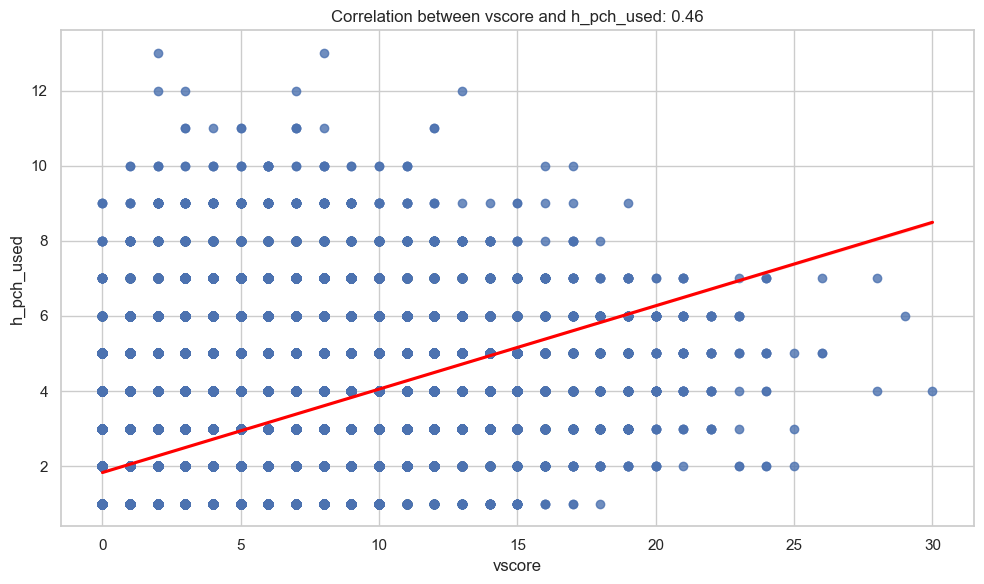

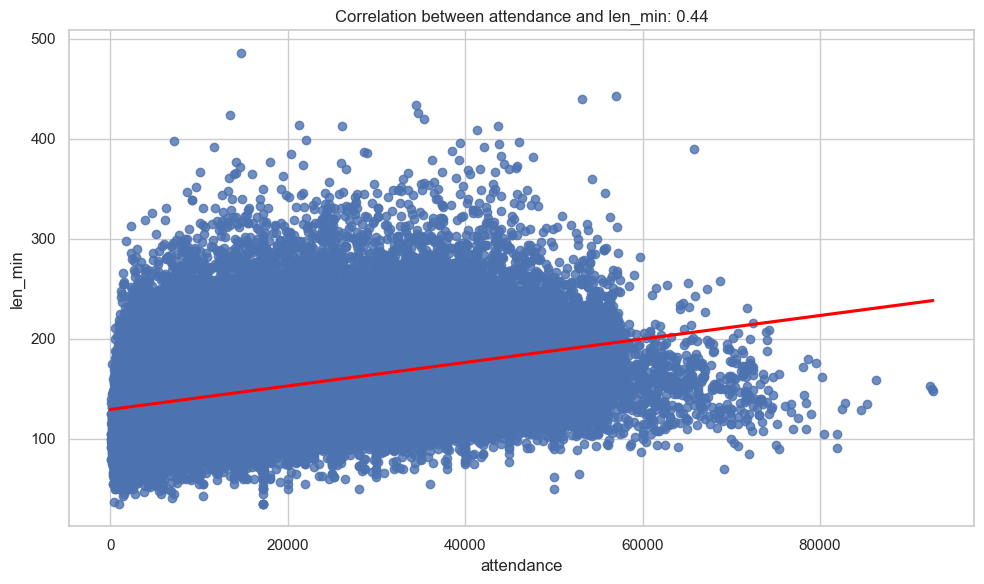

In [23]:
# Make sure that df_games and model_data have the same number of rows and are aligned
# If not, you may need to perform an operation to align them, such as sorting by a common column

# Combine the two dataframes
combined_data = pd.concat([model_data, df_games], axis=1)

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Define a strong correlation threshold
strong_correlation_threshold = 0.4

# Plotting configurations
sns.set(style="whitegrid")

# Create a mask to find correlations that are above the threshold and not on the diagonal (self-correlation)
mask = (correlation_matrix.abs() >= strong_correlation_threshold) & ~np.eye(correlation_matrix.shape[0], dtype=bool)

# Find the pairs of variables that have a strong correlation
strong_correlations = correlation_matrix.mask(~mask)

# Iterate over target variables and plot when strong correlation is found
for target in df_games.columns:
    # Skip if target is not in the list of target variables provided
    if target not in ['len_game', 'h_pch_used', 'h_errors', 'v_walks', 'len_min', 'v_sf', 'v_lft_base', 'h_assists']:
        continue
    
    # Find predictors that are strongly correlated with the target
    correlated_predictors = strong_correlations[target].dropna().index.tolist()
    
    for predictor in correlated_predictors:
        # Skip if predictor is actually a target variable
        if predictor in df_games.columns:
            continue
        
        # Plotting with seaborn
        plt.figure(figsize=(10, 6))
        sns.regplot(x=predictor, y=target, data=combined_data, line_kws={'color': 'red'})
        plt.title(f'Correlation between {predictor} and {target}: {correlation_matrix.loc[predictor, target]:.2f}')
        plt.xlabel(predictor)
        plt.ylabel(target)
        plt.tight_layout()
        plt.show()


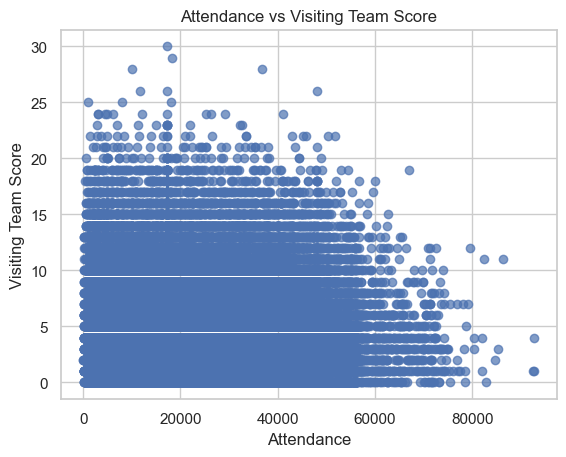

In [24]:
# 1. Distribution of attendance
# Scatter plot (attendance vs vscore)
plt.scatter(model_data['attendance'], model_data['vscore'], alpha=0.7)
plt.xlabel('Attendance')
plt.ylabel('Visiting Team Score')
plt.title('Attendance vs Visiting Team Score')
plt.grid(True)  # Add grid lines for better readability
plt.show()

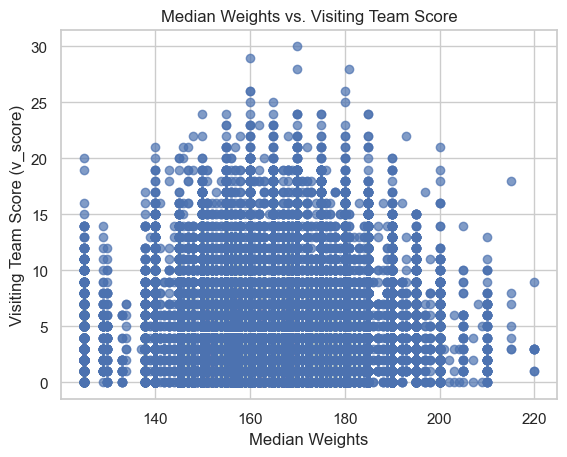

In [25]:
plt.scatter(model_data['median_weights'], model_data['vscore'], alpha=0.7)
plt.xlabel('Median Weights')
plt.ylabel('Visiting Team Score (v_score)')
plt.title('Median Weights vs. Visiting Team Score')
plt.grid(True)
plt.show()

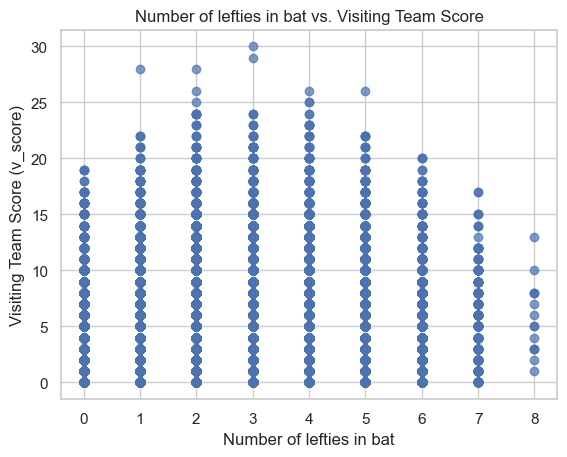

In [26]:
plt.scatter(model_data['count_L_bats'], model_data['vscore'], alpha=0.7)
plt.xlabel('Number of lefties in bat')
plt.ylabel('Visiting Team Score (v_score)')
plt.title('Number of lefties in bat vs. Visiting Team Score')
plt.grid(True)
plt.show()

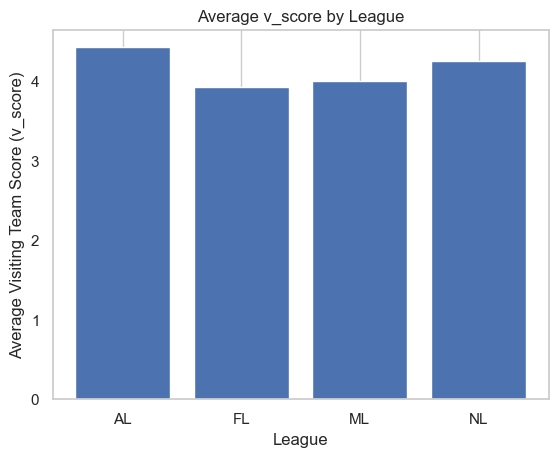

In [27]:
# Group data by league and calculate average vscore
avg_vscore_by_league = df.groupby('hleague')['vscore'].mean()

# Bar chart (average vscore vs league)
plt.bar(avg_vscore_by_league.index, avg_vscore_by_league.values)
plt.xlabel('League')
plt.ylabel('Average Visiting Team Score (v_score)')
plt.title('Average v_score by League')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability with categorical data
plt.grid(axis='y')
plt.show()

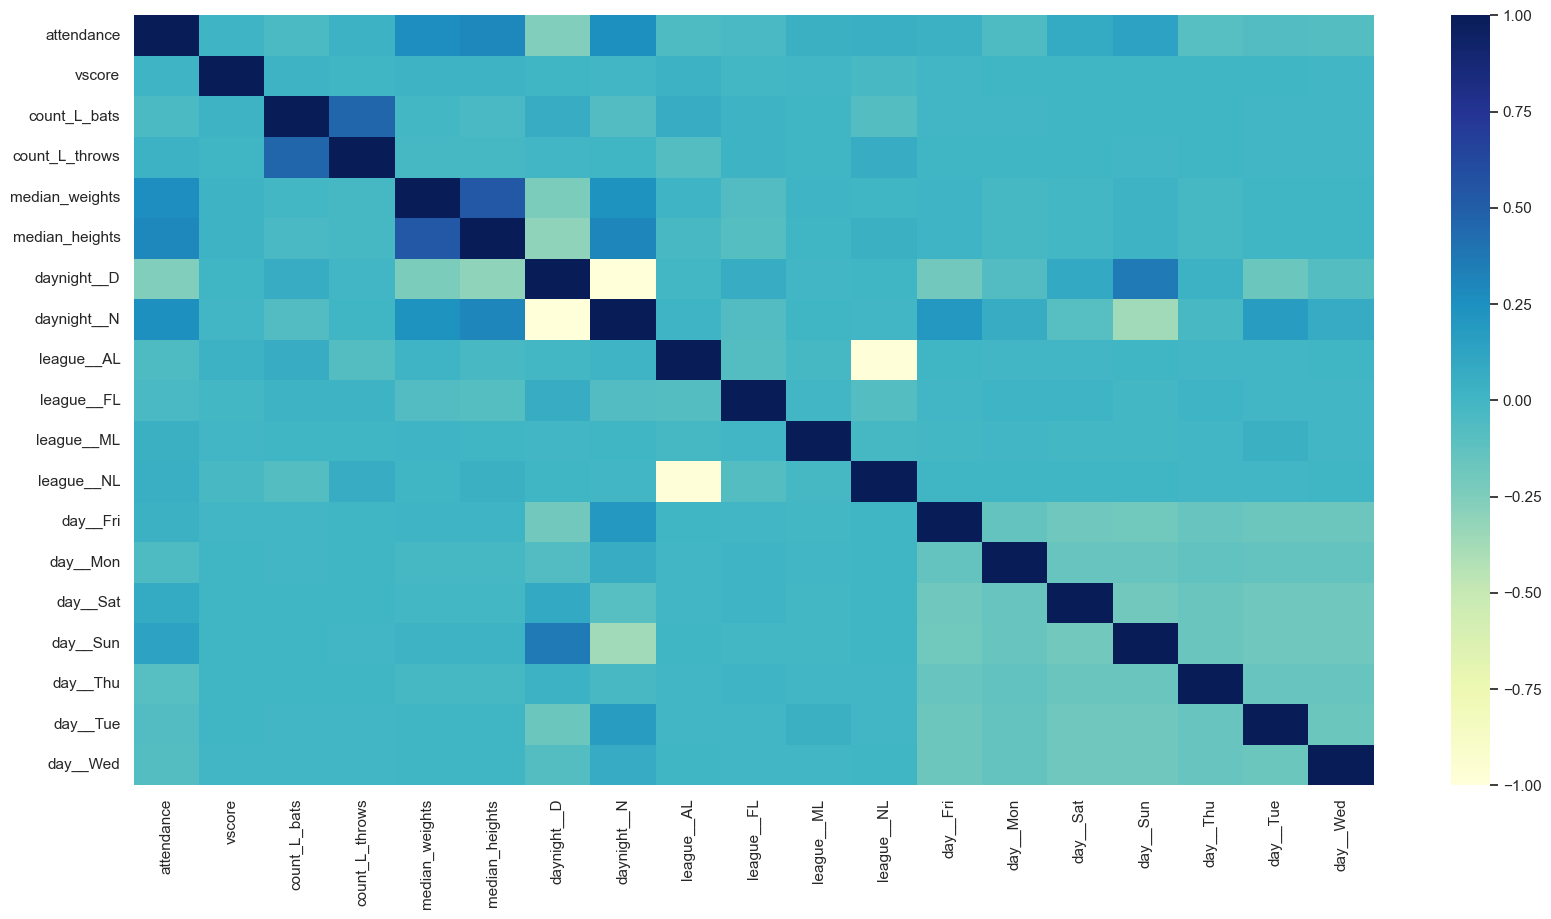

In [28]:
# Let's create the correlation matrix 
corr = model_data.corr()
plt.figure(figsize=(20,10))

# Create a heatmap
sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [29]:
# let's drop for multi co-linearity
model_data.drop(columns=['daynight__N'] , inplace=True)
# let's drop one column for multi co-linear
model_data.drop(columns=['day__Wed','league__AL','count_L_throws','median_heights'] , inplace=True)

In [30]:
# build a leniar regression model
X = model_data.drop('vscore', axis=1)
X_withconstant = sm.add_constant(X)
y = model_data['vscore']

In [31]:
model_data.isna().sum()

attendance        0
vscore            0
count_L_bats      0
median_weights    0
daynight__D       0
league__FL        0
league__ML        0
league__NL        0
day__Fri          0
day__Mon          0
day__Sat          0
day__Sun          0
day__Thu          0
day__Tue          0
dtype: int64

In [32]:
# 1. Instantiate Model
myregression = sm.OLS(y, X_withconstant)

# 2. Fit Model (this returns a seperate object with the parameters)
myregression_results = myregression.fit()

# Looking at the summary
myregression_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 vscore   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     31.40
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           5.00e-79
Time:                        04:04:38   Log-Likelihood:            -5.3990e+05
No. Observations:              210012   AIC:                         1.080e+06
Df Residuals:                  209998   BIC:                         1.080e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.1318      0.111     28.323      0.000       2.915       3.348
attendance      2.385e-06   5.76e-07      4.138      0.000    1.26e-06    3.51e-06
count_L_bats       0.0459      0.005      8.702      0.000       0.036       0.056
median_weights     0.0062      0.001      9.533      0.000       0.005       0.007
daynight__D        0.0923      0.017      5.486      0.000       0.059       0.125
league__FL        -0.4838      0.092     -5.286      0.000      -0.663      -0.304
league__ML        -0.5275      0.333     -1.586      0.113      -1.179       0.124
league__NL        -0.1662      0.014    -11.946      0.000      -0.193      -0.139
day__Fri          -0.0045      0.025     -0.179      0.858      -0.054       0.045
day__Mon           0.0629      0.028      2.267      0.023       0.009       0.117
day__Sat           0.0380      0.025      1.507      0.132      -0.011       0.088
day__Sun           0.0216      0.027      0.808      0.419      -0.031       0.074
day__Thu           0.0590      0.027      2.181      0.029       0.006       0.112
day__Tue           0.0699      0.026      2.731      0.006       0.020       0.120
==============================================================================
Omnibus:                    33152.083   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57226.559
Skew:                           1.039   Prob(JB):                         0.00
Kurtosis:                       4.492   Cond. No.                     1.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
Interpret = pd.DataFrame(myregression_results.params, columns=['coeffieceints']).reset_index()

In [34]:
Interpret

,index,coeffieceints
0,const,3.131778
1,attendance,0.000002
2,count_L_bats,0.045871
3,median_weights,0.006182
4,daynight__D,0.092327
5,league__FL,-0.483756
6,league__ML,-0.527520
7,league__NL,-0.166203
8,day__Fri,-0.004543
9,day__Mon,0.062856


In [35]:
#Get the coefficients from the trained model
coefficients = Interpret['coeffieceints']

# Get the feature names
feature_names = Interpret['index']

# Print the interpretation
print("Interpretation of Linear Regression Coefficients:")
for i, feature in enumerate(feature_names):
  coefficient = coefficients[i]
  sign = "+" if coefficient >= 0 else "-"
  print(f"{feature}: {sign}{abs(coefficient):.2f} - A {sign}coefficient indicates that a {abs(coefficient):.2f} unit increase in {feature} is associated with a {sign}{abs(coefficient):.2f} change in predicted vscore.")

Interpretation of Linear Regression Coefficients:
const: +3.13 - A +coefficient indicates that a 3.13 unit increase in const is associated with a +3.13 change in predicted vscore.
attendance: +0.00 - A +coefficient indicates that a 0.00 unit increase in attendance is associated with a +0.00 change in predicted vscore.
count_L_bats: +0.05 - A +coefficient indicates that a 0.05 unit increase in count_L_bats is associated with a +0.05 change in predicted vscore.
median_weights: +0.01 - A +coefficient indicates that a 0.01 unit increase in median_weights is associated with a +0.01 change in predicted vscore.
daynight__D: +0.09 - A +coefficient indicates that a 0.09 unit increase in daynight__D is associated with a +0.09 change in predicted vscore.
league__FL: -0.48 - A -coefficient indicates that a 0.48 unit increase in league__FL is associated with a -0.48 change in predicted vscore.
league__ML: -0.53 - A -coefficient indicates that a 0.53 unit increase in league__ML is associated with a 

In [36]:
# encode the categorical column
# Categorical features for one-hot encoding
categorical_cols = ['vteam', 'hteam', 'park_id']

# One-hot encoding
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
array_hot_encoded = ohe.fit_transform(df[categorical_cols])

data_hot_encoded = pd.DataFrame(array_hot_encoded, index=model_data.index)

# Other features
#data_other_cols = model_data.drop(columns=categorical_cols)

# Concatenate features
model_data = pd.concat([data_hot_encoded, model_data], axis=1)


# Convert all feature names to strings
model_data.columns = model_data.columns.astype(str)

In [37]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210012 entries, 0 to 210011
Columns: 252 entries, 0 to day__Tue
dtypes: float64(238), int32(14)
memory usage: 392.6 MB


In [38]:
X = model_data.drop('vscore', axis=1)
y = model_data['vscore']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=16)


# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Transform the training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# instantiate the model (using the default parameters)
#logreg = LogisticRegression(solver='newton-cg', class_weight='balanced', random_state=16)
model = LinearRegression()

# fit the model with data
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

In [39]:
feature_names = X_train.columns

# Evaluate the model's performance using mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared (R^2): {r2:.2f}")

adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(feature_names))
print(f"Adjusted R-squared: {adjusted_r2:.2f}")

Mean Squared Error: 11143373717513990832128.00
R-squared (R^2): -1108061938469208588288.00
Adjusted R-squared: -1121411438956765904896.00


In [40]:
model_data.head()

,0,1,2,3,4,5,6,7,8,9,...,daynight__D,league__FL,league__ML,league__NL,day__Fri,day__Mon,day__Sat,day__Sun,day__Thu,day__Tue
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,1,0,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,0


In [41]:
db_name = 'capstone'
db_host = 'localhost'
db_user = 'root'
db_password = 'rootroot'

connection = pymysql.connect(host=db_host,
                             user=db_user,
                             password=db_password,
                             db=db_name)

In [42]:
cursor = connection.cursor()

# Read data from the MySQL database into a Pandas DataFrameAssertionError
df_hruns = pd.read_sql('SELECT * FROM gm_logs', connection)

# Close the cursor and connection
cursor.close()
connection.close()

In [43]:
df_hruns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210012 entries, 0 to 210011
Data columns (total 46 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   playdate        210012 non-null  object 
 1   number          210012 non-null  int64  
 2   day             210012 non-null  object 
 3   vteam           210012 non-null  object 
 4   hteam           210012 non-null  object 
 5   vscore          210012 non-null  int64  
 6   hscore          210012 non-null  int64  
 7   hleague         210012 non-null  object 
 8   len_game        210012 non-null  int64  
 9   daynight        210012 non-null  object 
 10  park_id         210012 non-null  object 
 11  attendance      203255 non-null  float64
 12  len_min         207136 non-null  float64
 13  v_at_bats       210012 non-null  int64  
 14  v_hits          210012 non-null  int64  
 15  v_doubles       210012 non-null  int64  
 16  v_triples       210012 non-null  int64  
 17  v_hruns   

In [44]:
df_hruns.drop(columns=['number', 'hscore','v_win_val'],axis=1 , inplace=True)

In [45]:
# Fill NaN values in 'attendance' column with median and convert to int
#df_hruns.drop(columns=['day', 'hteam', 'hleague', 'park_id'],inplace=True)

# Create new columns with conditional logic for handling nulls

df_hruns["count_L_bats"] = df_hruns["player_bats"].fillna("").str.count("L")
df_hruns["count_L_throws"] = df_hruns["player_throws"].fillna("").str.count("L")

# Ensure the new columns have integer data types
df_hruns["count_L_bats"] = df_hruns["count_L_bats"].astype("int")
df_hruns["count_L_throws"] = df_hruns["count_L_throws"].astype("int")


# Create a new column with processed median
df_hruns['median_weights'] = df_hruns['player_weights'].apply(process_weights)
df_hruns['median_heights'] = df_hruns['player_heights'].apply(process_weights)


df_hruns.fillna(method='ffill',inplace=True)
df_hruns.drop_duplicates()
df_hruns.dropna(how='any',inplace=True)

# Fill NaN values in 'attendance' column with median and convert to int
df_hruns['attendance'] = df_hruns['attendance'].astype(int)
df_hruns['median_weights'] = df_hruns['median_weights'].astype(int)
df_hruns['median_heights'] = df_hruns['median_heights'].astype(int)

# Replace 0s in 'median_weights' with the median of the entire column (consider other imputation strategies if needed)
df_hruns['median_weights'] = df_hruns['median_weights'].replace(0, df_hruns['median_weights'].median())
df_hruns['median_heights'] = df_hruns['median_heights'].replace(0, df_hruns['median_heights'].median())
df_hruns['attendance'] = df_hruns['attendance'].replace(0, df_hruns['attendance'].median())


df_hruns.drop(columns=['player_weights','player_heights', 'player_throws', 'player_bats'],axis=1 , inplace=True)

#df_hruns['attendance'] = df_hruns['attendance'].fillna(df_hruns['attendance'].median()).astype(int)

# data errors , modify the negative values to the absolute values
# Change negative values to absolute values
df_hruns['v_rbi'] = df_hruns['v_rbi'].abs()
df_hruns['v_sf'] = df_hruns['v_sf'].abs()
df_hruns['v_sh'] = df_hruns['v_sh'].abs()
df_hruns['v_hit_pitch'] = df_hruns['v_hit_pitch'].abs()
df_hruns['v_walks'] = df_hruns['v_walks'].abs()
df_hruns['v_in_walks'] = df_hruns['v_in_walks'].abs()
df_hruns['v_strkouts'] = df_hruns['v_strkouts'].abs()
df_hruns['v_cau_stl'] = df_hruns['v_cau_stl'].abs()
df_hruns['v_grd_dbl'] = df_hruns['v_grd_dbl'].abs()
df_hruns['v_af_ci'] = df_hruns['v_af_ci'].abs()
df_hruns['h_in_runs'] = df_hruns['h_in_runs'].abs()
df_hruns['h_er_runs'] = df_hruns['h_er_runs'].abs()

In [46]:
df_hruns_copy = df_hruns.copy()
df_hruns.drop(columns=['playdate'],axis=1 , inplace=True)

In [47]:

# Specify columns for one-hot encoding
categorical_cols = ['day', 'daynight', 'hteam', 'vteam', 'hleague', 'park_id']

# One-Hot Encoding
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
array_hot_encoded = ohe.fit_transform(df_hruns[categorical_cols])
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=df_hruns.index)

# Extract non-encoded columns
data_other_cols = df_hruns.drop(columns=categorical_cols)

# Concatenate encoded and non-encoded data
data_out = pd.concat([data_hot_encoded, data_other_cols], axis=1)

dta_out_v_rbi = data_out.copy()

# Convert column names to strings
data_out.columns = data_out.columns.astype(str)

# DRopping RBI which is same as team score
data_out.drop(columns = ['v_rbi' ,'h_in_runs','h_er_runs','v_hits','v_at_bats','v_hruns','h_putouts','v_strkouts','v_triples','v_doubles'],axis=1,inplace=True)

# Feature variable (all columns except v_hruns)
X = data_out.drop('vscore', axis=1)

# Target variable (v_hruns)
y = data_out['vscore']

# Split data into training and testing sets (75% for training, 25% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [48]:
# Define a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Grid of parameters to choose from
parameters = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    # More parameters can be added here
}

# Perform grid search
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

# Best model after grid search
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)
print(f"Best model R2 score: {r2:.2f}")

Best model R2 score: 0.58


In [49]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 1.57


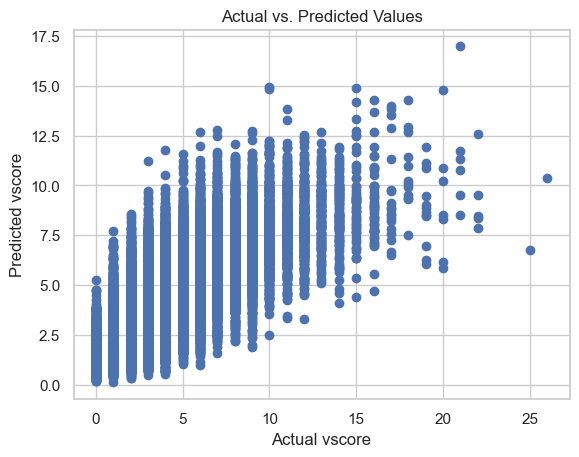

In [50]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual vscore")
plt.ylabel("Predicted vscore")
plt.title("Actual vs. Predicted Values")
plt.show()

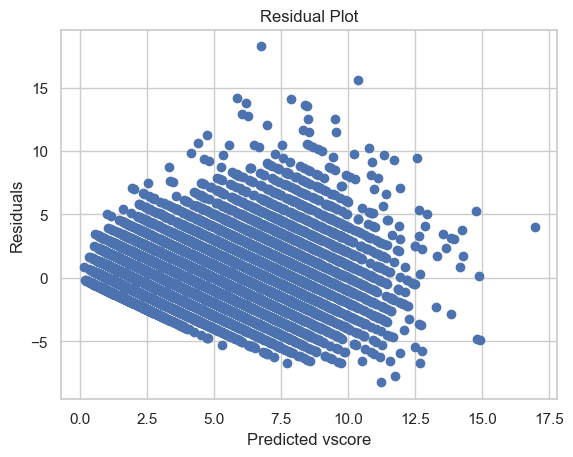

In [51]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted vscore")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

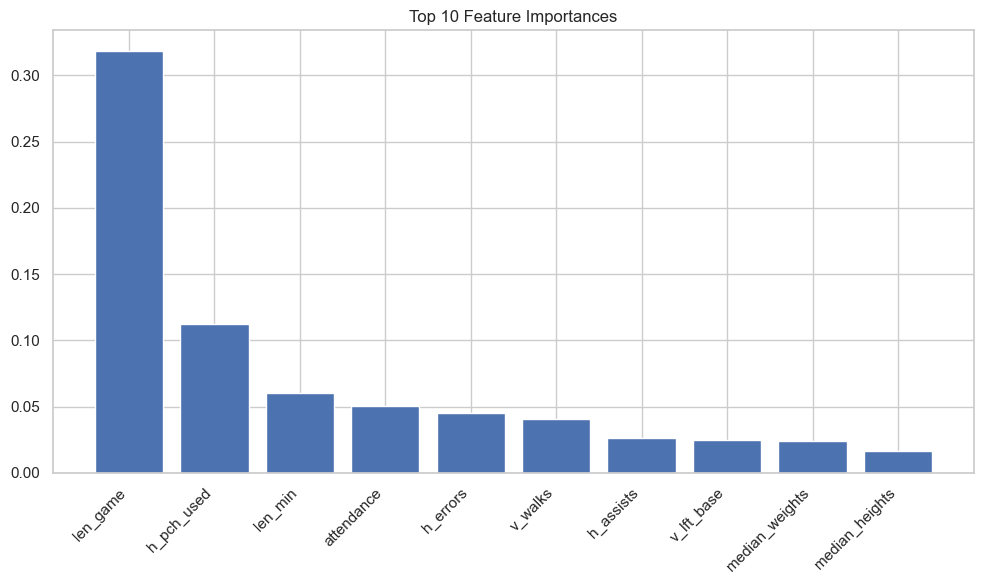

Top 10 Most Influential Features:
1. len_game (Importance: 0.3180)
2. h_pch_used (Importance: 0.1121)
3. len_min (Importance: 0.0602)
4. attendance (Importance: 0.0501)
5. h_errors (Importance: 0.0454)
6. v_walks (Importance: 0.0407)
7. h_assists (Importance: 0.0260)
8. v_lft_base (Importance: 0.0246)
9. median_weights (Importance: 0.0239)
10. median_heights (Importance: 0.0168)


In [52]:
# Get feature importances from the trained model
#importances = model.feature_importances_
importances = best_model.named_steps['regressor'].feature_importances_
sorted_indices = np.argsort(importances)[::-1]

# Define the number of top features to plot
num_top_features = 10

# Plot feature importances for the top 10 features only
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.bar(range(num_top_features), importances[sorted_indices[:num_top_features]], align='center')
plt.xticks(range(num_top_features), np.array(X.columns)[sorted_indices[:num_top_features]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print out the top 10 features and their importance values
print("Top 10 Most Influential Features:")
for i in range(num_top_features):
    print(f"{i+1}. {X.columns[sorted_indices[i]]} (Importance: {importances[sorted_indices[i]]:.4f})")


In [53]:
# Define a pipeline that includes scaling and the regressor
pipeline_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Hyperparameter grid
param_grid_gb = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5]
}

# Set up GridSearchCV
grid_search_gb = GridSearchCV(estimator=pipeline_gb, param_grid=param_grid_gb, 
                              scoring='r2', cv=3, verbose=2, n_jobs=-1)

# Train the model
grid_search_gb.fit(X_train, y_train)

# Best estimator
best_gb_model = grid_search_gb.best_estimator_

# Make predictions with the best model
y_pred_gb = best_gb_model.predict(X_test)

# Calculate R2 score for the best gradient boosting model
r2_gb = r2_score(y_test, y_pred_gb)
print(f"Best Gradient Boosting R2 score: {r2_gb:.2f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Gradient Boosting R2 score: 0.59


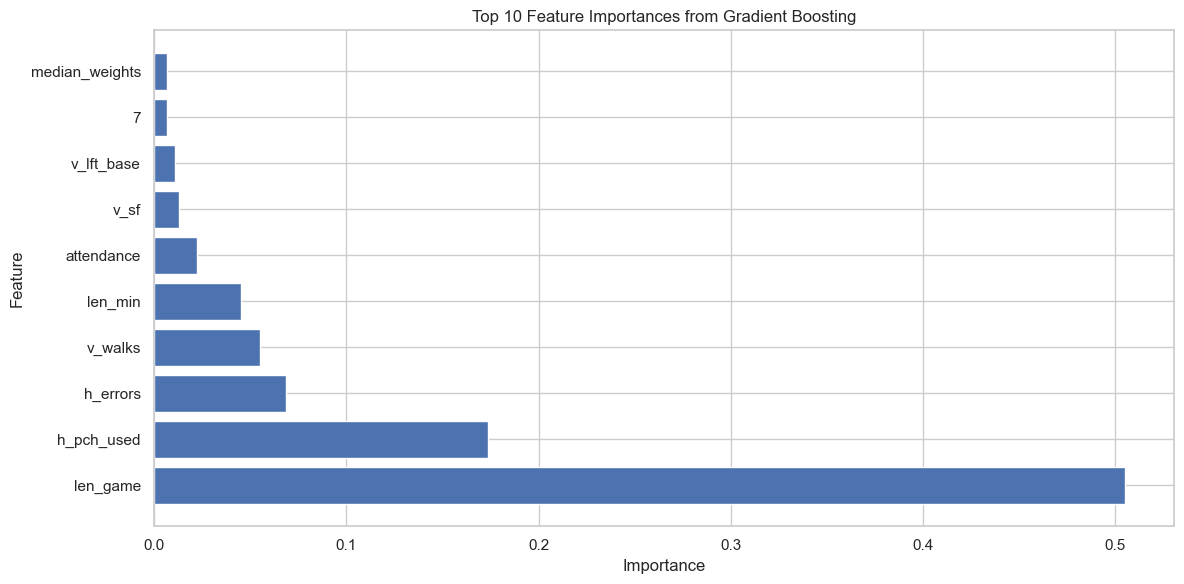

In [54]:
# Extract feature names from the original dataset (before any encoding or transformations)
original_feature_names = X_train.columns

# Get feature importances from the best model (assuming the model is the last step in the pipeline)
feature_importances_gb = best_gb_model.named_steps['regressor'].feature_importances_

# Match feature importances with the original feature names
features_and_importances = zip(original_feature_names, feature_importances_gb)
sorted_features_and_importances = sorted(features_and_importances, key=lambda x: x[1], reverse=True)

# Plot feature importances for the top 10 features
plt.figure(figsize=(12, 6))
plt.title('Top 10 Feature Importances from Gradient Boosting')
top_features = sorted_features_and_importances[:10]
features, importances = zip(*top_features)
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [56]:
db_name = 'capstone'
db_host = 'localhost'
db_user = 'root'
db_password = 'rootroot'

connection = pymysql.connect(host=db_host,
                             user=db_user,
                             password=db_password,
                             db=db_name)

In [57]:
cursor = connection.cursor()

# Read data from the MySQL database into a Pandas DataFrameAssertionError
df_time = pd.read_sql('SELECT playdate, vscore, vteam FROM gm_logs', connection)

# Close the cursor and connection
cursor.close()
connection.close()

In [58]:
df_time["playdate"] = pd.to_datetime(df_time["playdate"])
# Group By yankees
df_time = df_time.set_index("playdate")
df_time_yankees = df_time[df_time['vteam'] == 'NYA']
df_time_mets = df_time[df_time['vteam'] == 'NYN']
df_time_yankees.head()

,vscore,vteam
playdate,,
1908-09-14,1,NYA
1903-09-01,5,NYA
1908-09-15,1,NYA
1903-09-02,11,NYA
1903-09-03,3,NYA


In [59]:
train_sel = df_time_yankees.index <= "1997-01-01"
test_sel = df_time_yankees.index > "1997-01-01"
train = df_time_yankees.loc[train_sel,:]
test = df_time_yankees.loc[test_sel, :]

#mets team train test split
train_sel_mets = df_time_mets.index <= "2010-01-01"
test_sel_mets = df_time_mets.index > "2010-01-01"
train_mets = df_time_mets.loc[train_sel_mets,:]
test_mets = df_time_mets.loc[test_sel_mets, :]

In [60]:
selector = np.logical_or(test_sel,train_sel)
as_series = df_time_yankees.loc[selector, "vscore"]

prophet_train = pd.DataFrame({"ds": as_series.index,
                              "y": as_series.values})

# mets prophet data
selector_mets = np.logical_or(train_sel_mets,test_sel_mets)
as_series_mets = df_time_mets.loc[selector_mets, "vscore"]

prophet_train_mets = pd.DataFrame({"ds": as_series_mets.index,
                              "y": as_series_mets.values})

In [61]:
#Yankees data
# Group by the month and take the avg of visting team score
monthly_avg_y = prophet_train.resample('M', on='ds')['y'].mean()

# Converting the index to datetime format
monthly_avg_y.index = pd.to_datetime(monthly_avg_y.index)

# Coverrt the monthly datfarme gaian to type of prophet datfarme 
df_new = monthly_avg_y.reset_index()  # Convert Series to DataFrame
df_new.columns = ['ds', 'y']          # Rename columns


# mets Data
# Group by the month and take the avg of visting team score
monthly_avg_m = prophet_train_mets.resample('M', on='ds')['y'].mean()

# Converting the index to datetime format
monthly_avg_m.index = pd.to_datetime(monthly_avg_m.index)

# Coverrt the monthly datfarme gaian to type of prophet datfarme 
df_new_mets = monthly_avg_m.reset_index()  # Convert Series to DataFrame
df_new_mets.columns = ['ds', 'y']          # Rename columns


In [62]:
model_time = Prophet(yearly_seasonality=True)
model_time = model_time.fit(df_new)

05:14:21 - cmdstanpy - INFO - Chain [1] start processing
05:14:21 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
model_time_mets = Prophet(yearly_seasonality=True)
model_time_mets = model_time_mets.fit(df_new_mets)

05:14:25 - cmdstanpy - INFO - Chain [1] start processing
05:14:25 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
future = model_time.make_future_dataframe(periods=60,freq="M")
future_mets = model_time_mets.make_future_dataframe(periods=60,freq="M")

In [65]:
# Python
forecast = model_time.predict(future)
forecast_mets = model_time_mets.predict(future)

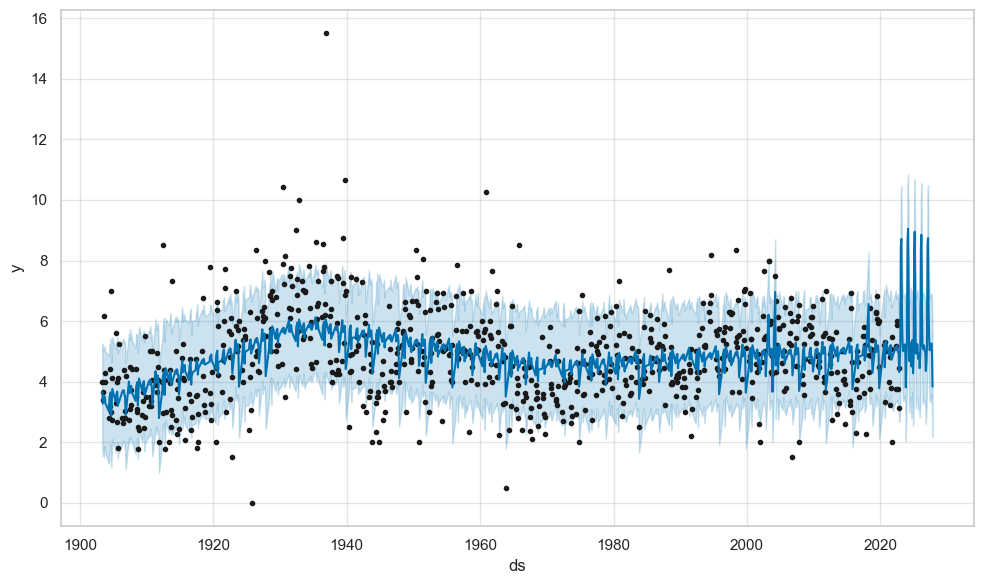

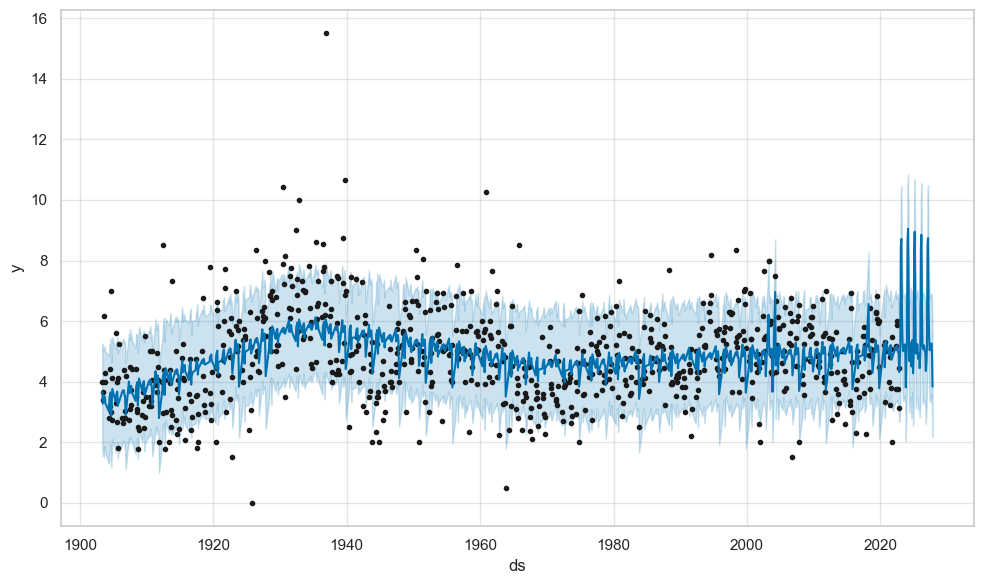

In [66]:
 model_time.plot(forecast)

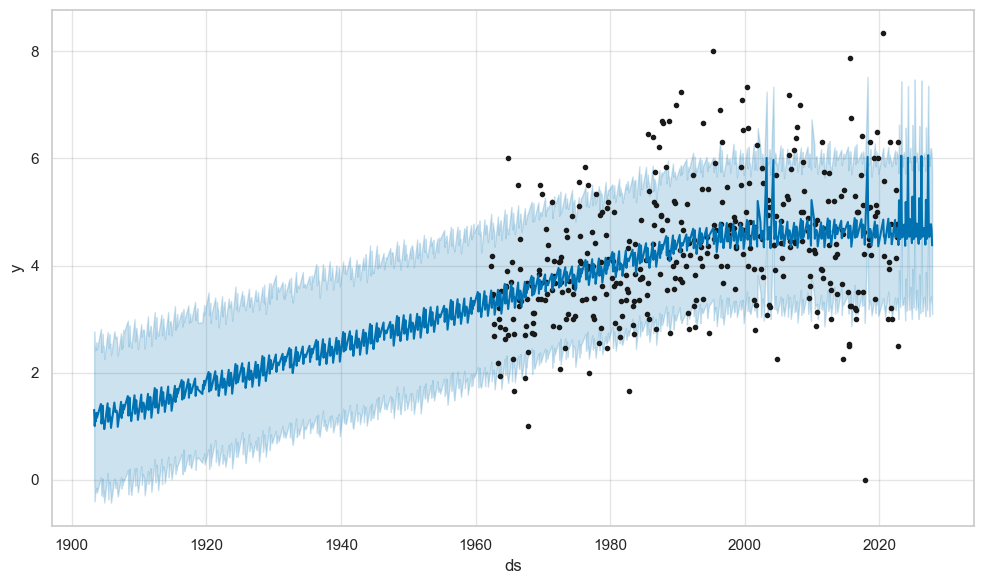

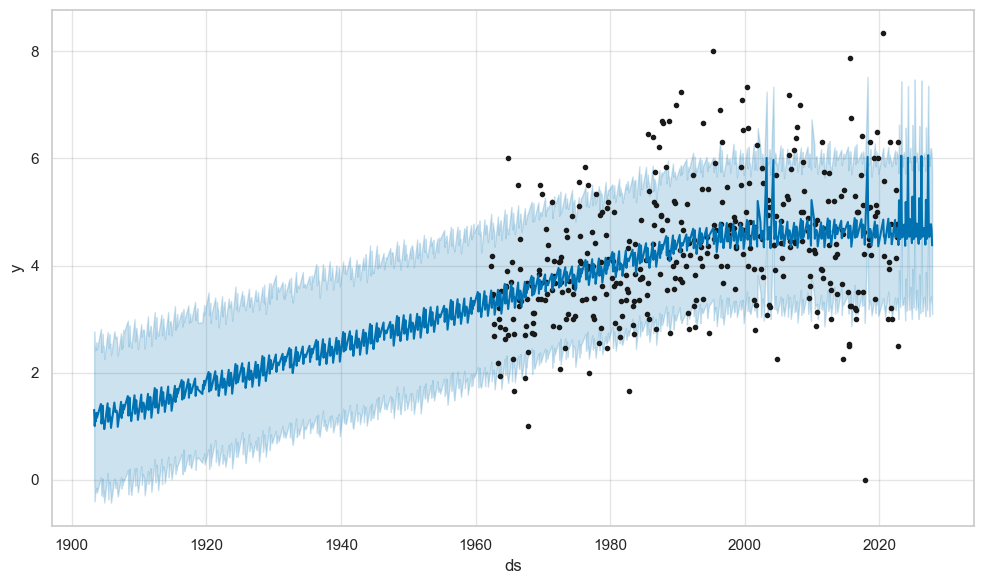

In [67]:
 model_time_mets.plot(forecast_mets)

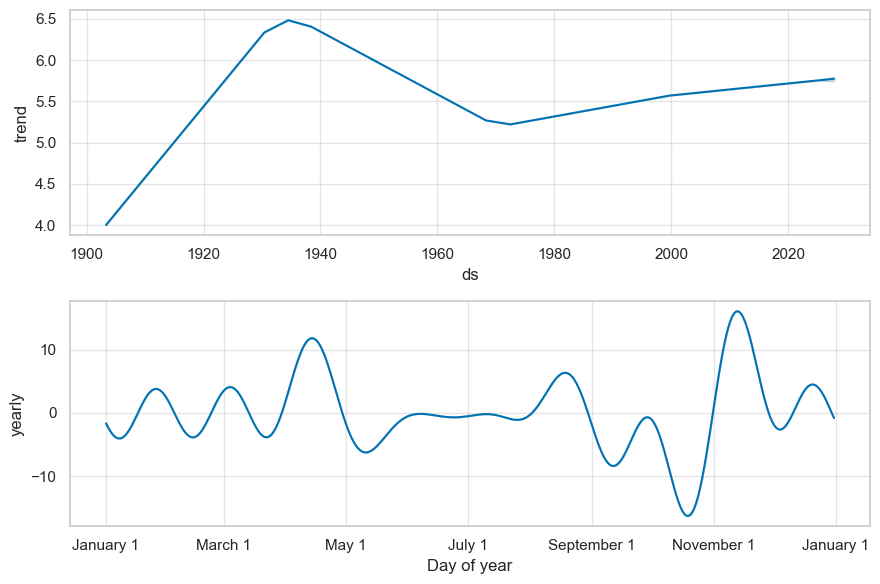

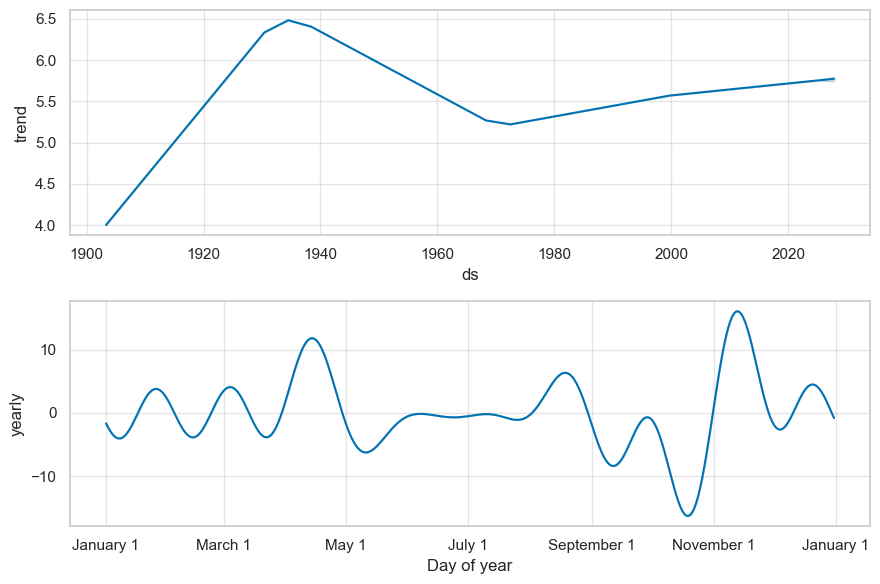

In [68]:
model_time.plot_components(forecast)

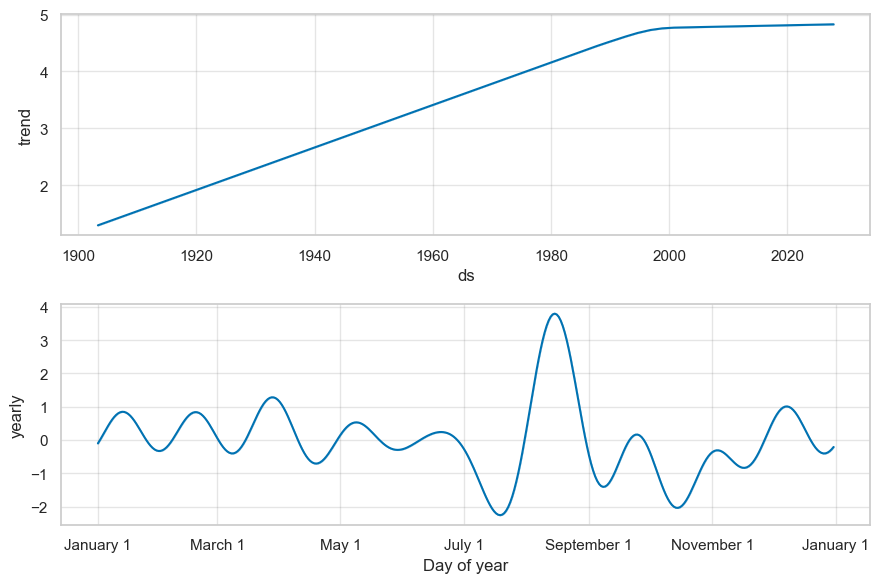

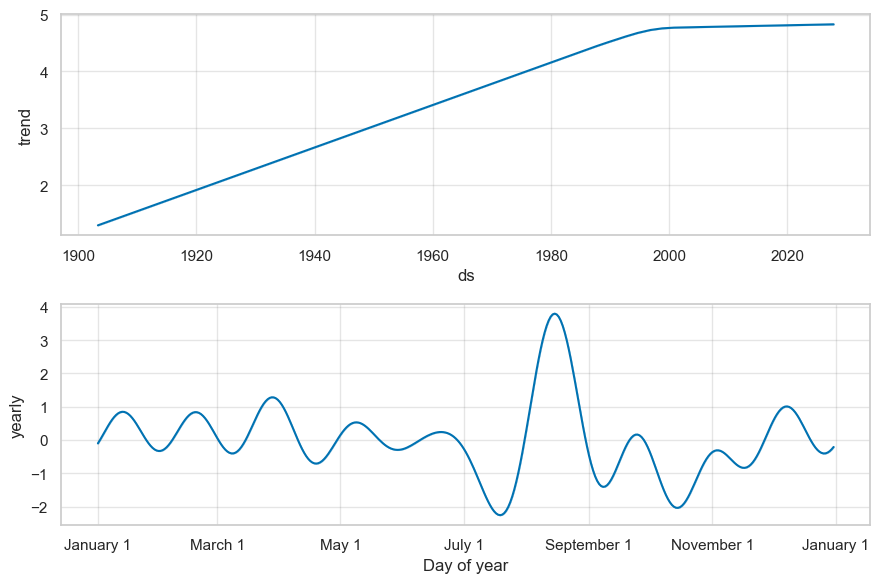

In [69]:
model_time_mets.plot_components(forecast_mets)

In [118]:
db_name = 'capstone'
db_host = 'localhost'
db_user = 'root'
db_password = 'rootroot'

connection = pymysql.connect(host=db_host,
                             user=db_user,
                             password=db_password,
                             db=db_name)

In [119]:
cursor = connection.cursor()

# Read data from the MySQL database into a Pandas DataFrameAssertionError
df_v_ofnsv = pd.read_sql('SELECT  vteam,vscore,v_at_bats,v_hits,v_doubles,v_triples,v_hruns,v_rbi,v_sh,v_sf,v_hit_pitch,v_walks,v_in_walks,v_strkouts,v_stlbase,v_cau_stl,v_grd_dbl,v_af_ci,v_lft_base  FROM gm_logs', connection)

# Close the cursor and connection
cursor.close()
connection.close()

In [120]:
# Change negative values to absolute values
df_v_ofnsv['v_rbi'] = df_v_ofnsv['v_rbi'].abs()
df_v_ofnsv['v_sf'] = df_v_ofnsv['v_sf'].abs()
df_v_ofnsv['v_sh'] = df_v_ofnsv['v_sf'].abs()
df_v_ofnsv['v_hit_pitch'] = df_v_ofnsv['v_hit_pitch'].abs()
df_v_ofnsv['v_walks'] = df_v_ofnsv['v_walks'].abs()
df_v_ofnsv['v_in_walks'] = df_v_ofnsv['v_in_walks'].abs()
df_v_ofnsv['v_strkouts'] = df_v_ofnsv['v_strkouts'].abs()
df_v_ofnsv['v_cau_stl'] = df_v_ofnsv['v_cau_stl'].abs()
df_v_ofnsv['v_grd_dbl'] = df_v_ofnsv['v_grd_dbl'].abs()
df_v_ofnsv['v_af_ci'] = df_v_ofnsv['v_af_ci'].abs()

In [121]:
df_v_ofnsv.isna().sum()

vteam          0
vscore         0
v_at_bats      0
v_hits         0
v_doubles      0
v_triples      0
v_hruns        0
v_rbi          0
v_sh           0
v_sf           0
v_hit_pitch    0
v_walks        0
v_in_walks     0
v_strkouts     0
v_stlbase      0
v_cau_stl      0
v_grd_dbl      0
v_af_ci        0
v_lft_base     0
dtype: int64

In [122]:
df_v_ofnsv.ffill(inplace=True)

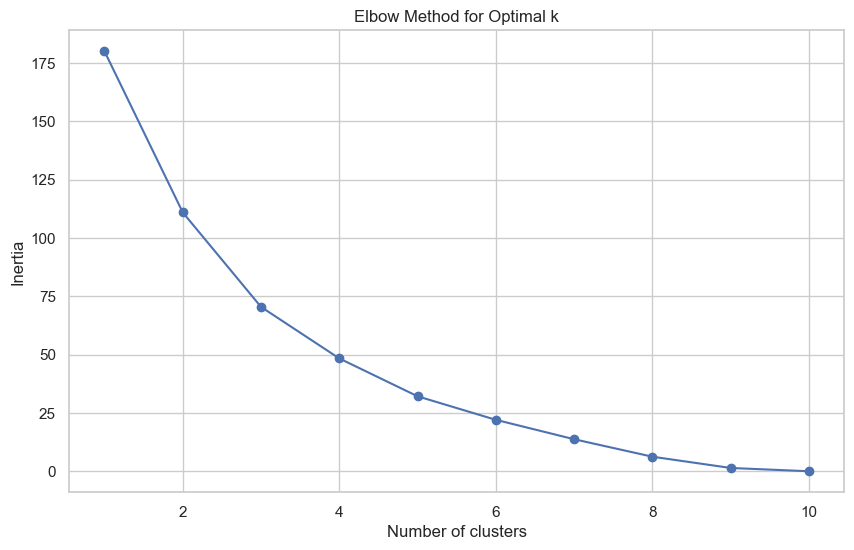

vteam
CHA    0
PHI    0
PIT    0
SLN    0
LAN    1
OAK    1
WAS    1
COL    2
BOS    3
NYA    3
Name: cluster, dtype: int32


In [123]:
# Assuming df_v_ofnsv is already loaded with the baseball game logs data.

# Filter the DataFrame for specific teams
selected_teams = ['NYA', 'PHI', 'SLN', 'LAN', 'BOS', 'PIT', 'WAS', 'CHA', 'COL', 'OAK']
df_selected = df_v_ofnsv[df_v_ofnsv['vteam'].isin(selected_teams)]

# Aggregate the stats by team
# You are calculating the mean, assuming missing values are handled as per your dataset's requirements
df_team_offensive_stats = df_selected.groupby('vteam').mean()

# Scaling the features
scaler = StandardScaler()
df_offensive_scaled = scaler.fit_transform(df_team_offensive_stats)

# Finding the optimal number of clusters using the elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_offensive_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve to find the optimal k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the number of clusters based on the elbow plot
optimal_clusters = 4  # Replace this with the number you determine is best from the plot

# Run the KMeans clustering algorithm with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(df_offensive_scaled)

# Add the cluster labels to the aggregated stats
df_team_offensive_stats['cluster'] = clusters

# Now let's see which teams are in each cluster
print(df_team_offensive_stats['cluster'].sort_values())


In [101]:
db_name = 'capstone'
db_host = 'localhost'
db_user = 'root'
db_password = 'rootroot'

connection = pymysql.connect(host=db_host,
                             user=db_user,
                             password=db_password,
                             db=db_name)

In [102]:
cursor = connection.cursor()

# Read data from the MySQL database into a Pandas DataFrameAssertionError
df_h_dfnsv = pd.read_sql('SELECT hteam,h_pch_used,h_in_runs,h_er_runs,h_wld_pitch,h_balks,h_putouts,h_assists,h_errors,h_pballs,h_dplays,h_tplays FROM gm_logs', connection)

# Close the cursor and connection
cursor.close()
connection.close()

In [105]:
df_h_dfnsv['h_in_runs'] = df_h_dfnsv['h_in_runs'].abs()
df_h_dfnsv['h_er_runs'] = df_h_dfnsv['h_er_runs'].abs()      

In [106]:
df_h_dfnsv.ffill(inplace=True)

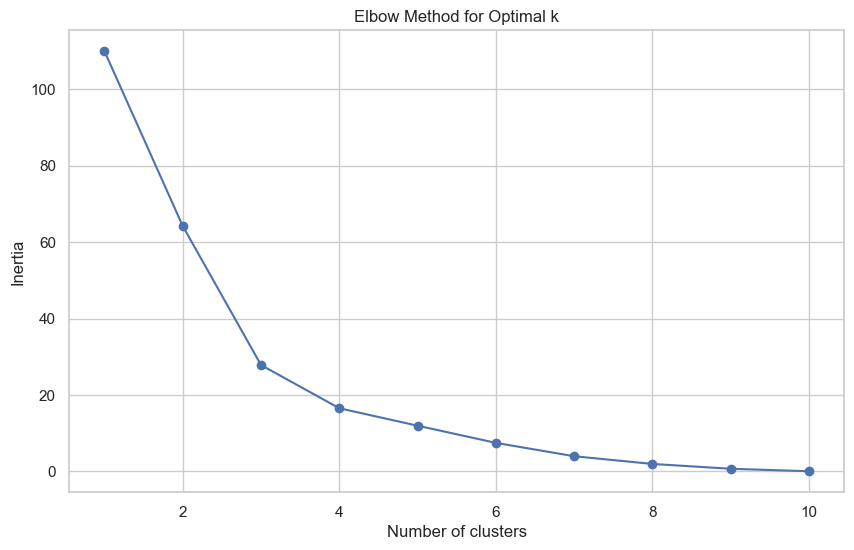

hteam
LAN    0
OAK    0
WAS    0
BOS    1
CHA    1
NYA    1
PHI    1
PIT    1
SLN    1
COL    2
Name: cluster, dtype: int32


In [107]:

# Filter the DataFrame for specific teams
selected_teams = ['NYA', 'PHI', 'SLN', 'LAN', 'BOS', 'PIT', 'WAS', 'CHA', 'COL', 'OAK']
df_selected = df_h_dfnsv[df_h_dfnsv['hteam'].isin(selected_teams)]

# Aggregate the stats by team
# You are calculating the mean, assuming missing values are handled as per your dataset's requirements
df_team_defensive_stats = df_selected.groupby('hteam').mean()

# Scaling the features
scaler = StandardScaler()
df_defensive_scaled = scaler.fit_transform(df_team_defensive_stats)

# Finding the optimal number of clusters using the elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_defensive_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve to find the optimal k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the number of clusters based on the elbow plot
optimal_clusters = 3  # Replace this with the number you determine is best from the plot

# Run the KMeans clustering algorithm with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(df_defensive_scaled)

# Add the cluster labels to the aggregated stats
df_team_defensive_stats['cluster'] = clusters

# Now let's see which teams are in each cluster
print(df_team_defensive_stats['cluster'].sort_values())


In [108]:
db_name = 'capstone'
db_host = 'localhost'
db_user = 'root'
db_password = 'rootroot'

connection = pymysql.connect(host=db_host,
                             user=db_user,
                             password=db_password,
                             db=db_name)

In [109]:
cursor = connection.cursor()

# Read data from the MySQL database into a Pandas DataFrame
sql_query = ("SELECT DISTINCT " +
             "vteam, hteam, vscore, hscore, v_at_bats, v_hits, v_doubles, v_triples, v_hruns, v_rbi, v_sh, v_sf, " +
             "v_hit_pitch, v_walks, v_in_walks, v_strkouts, v_stlbase, v_cau_stl, v_grd_dbl, v_af_ci, v_lft_base, v_win_val " +
             "FROM " +
             "gm_logs gl " +
             "WHERE " +
             "(gl.vteam = 'NYA' OR gl.vteam = 'NYN') AND (gl.hteam = 'NYN' OR gl.hteam = 'NYA')")
df_games = pd.read_sql(sql_query, connection)

# Close the cursor and connection
cursor.close()
connection.close()

In [115]:
# Change negative values to absolute values
df_games['v_rbi'] = df_games['v_rbi'].abs()
df_games['v_sf'] = df_games['v_sf'].abs()
df_games['v_sh'] = df_games['v_sf'].abs()
df_games['v_hit_pitch'] = df_games['v_hit_pitch'].abs()
df_games['v_walks'] = df_games['v_walks'].abs()
df_games['v_in_walks'] = df_games['v_in_walks'].abs()
df_games['v_strkouts'] = df_games['v_strkouts'].abs()
df_games['v_cau_stl'] = df_games['v_cau_stl'].abs()
df_games['v_grd_dbl'] = df_games['v_grd_dbl'].abs()
df_games['v_af_ci'] = df_games['v_af_ci'].abs()

In [116]:
df_games.columns

Index(['vteam', 'hteam', 'vscore', 'hscore', 'v_at_bats', 'v_hits',
       'v_doubles', 'v_triples', 'v_hruns', 'v_rbi', 'v_sh', 'v_sf',
       'v_hit_pitch', 'v_walks', 'v_in_walks', 'v_strkouts', 'v_stlbase',
       'v_cau_stl', 'v_grd_dbl', 'v_af_ci', 'v_lft_base', 'v_win_val',
       'run_differential_visiting'],
      dtype='object')

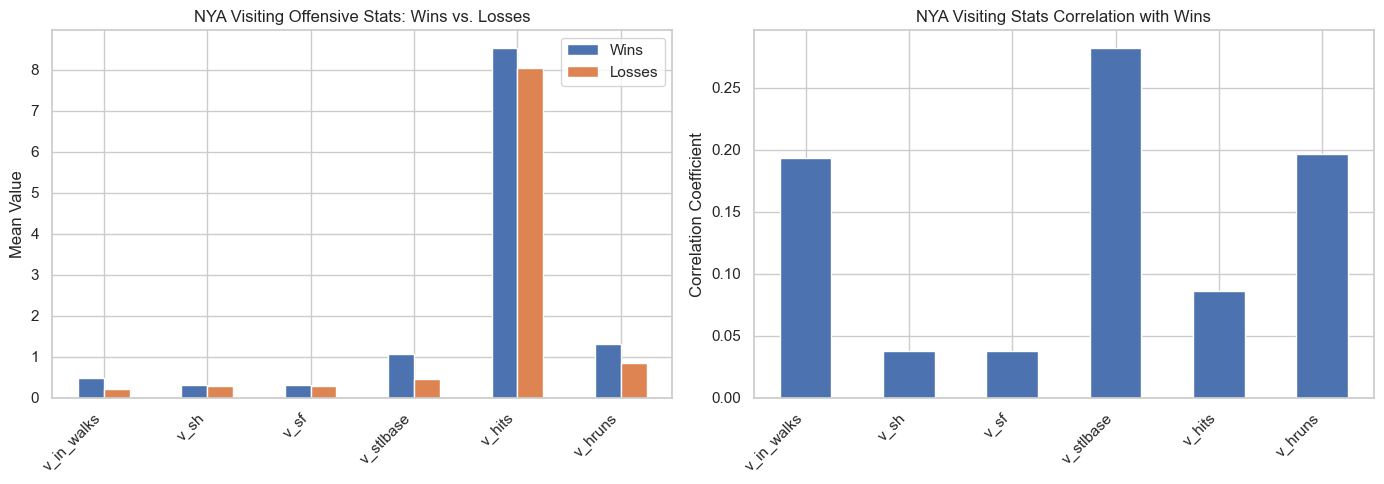

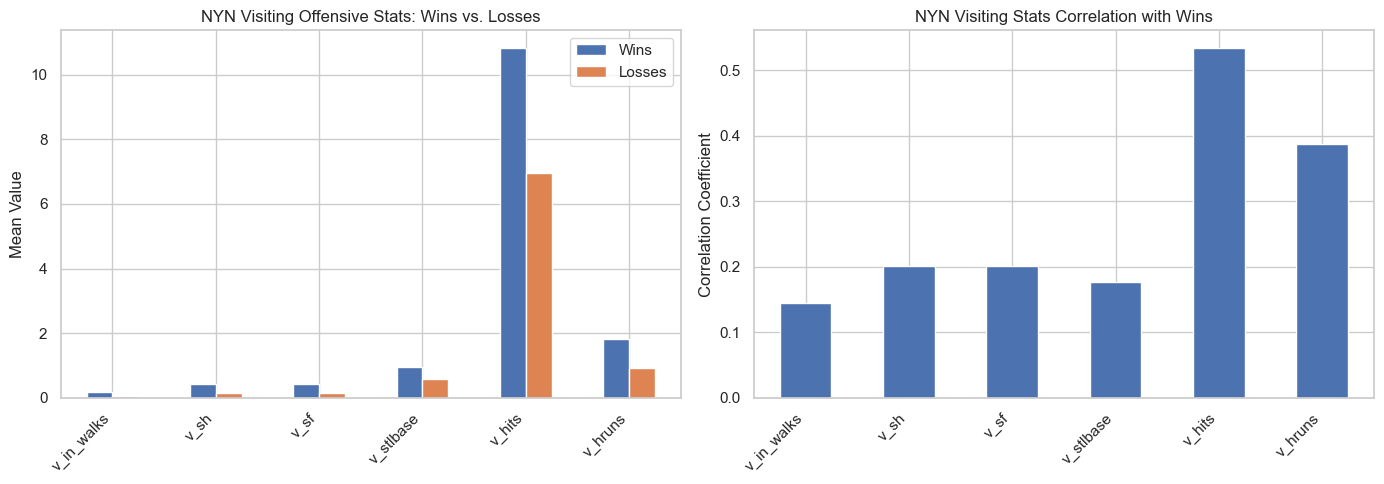

In [117]:
# Calculate run differential for visiting team
df_games['run_differential_visiting'] = df_games['vscore'] - df_games['hscore']

# Function to calculate and plot mean offensive stats in wins vs. losses, and correlation
def analyze_team_performance(df_games, team_code):
    # Filter games for when the team is visiting
    team_visiting_games = df_games[df_games['vteam'] == team_code]
    
    # Calculate win/loss stats when the team is visiting
    team_visiting_wins = team_visiting_games[team_visiting_games['v_win_val'] == 1]
    team_visiting_losses = team_visiting_games[team_visiting_games['v_win_val'] == 0]

    # Calculate the mean offensive stats in wins vs. losses for visiting team
    offensive_stats = ['v_in_walks', 'v_sh','v_sf', 'v_stlbase', 'v_hits', 'v_hruns']
    mean_stats_visiting_wins = team_visiting_wins[offensive_stats].mean()
    mean_stats_visiting_losses = team_visiting_losses[offensive_stats].mean()

    # Calculate correlation of offensive stats and wins for visiting team
    stats_correlation_visiting = team_visiting_games[offensive_stats + ['v_win_val']].corr()['v_win_val']

    # Plotting mean stats comparison for visiting team
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Mean stats for visiting team wins vs. losses
    mean_stats_df_visiting = pd.DataFrame({'Wins': mean_stats_visiting_wins, 'Losses': mean_stats_visiting_losses})
    mean_stats_df_visiting.plot(kind='bar', ax=ax[0])
    ax[0].set_title(f'{team_code} Visiting Offensive Stats: Wins vs. Losses')
    ax[0].set_ylabel('Mean Value')
    ax[0].set_xticklabels(offensive_stats, rotation=45, ha='right')
    
    # Correlation with visiting wins
    stats_correlation_visiting.drop('v_win_val').plot(kind='bar', ax=ax[1])
    ax[1].set_title(f'{team_code} Visiting Stats Correlation with Wins')
    ax[1].set_ylabel('Correlation Coefficient')
    ax[1].set_xticklabels(offensive_stats, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Analyze team performance for Yankees and Mets
analyze_team_performance(df_games, 'NYA')  # Yankees as visiting team
analyze_team_performance(df_games, 'NYN')  # Mets as visiting team


In [8]:
db_name = 'capstone'
db_host = 'localhost'
db_user = 'root'
db_password = 'rootroot'

connection = pymysql.connect(host=db_host,
                             user=db_user,
                             password=db_password,
                             db=db_name)

In [9]:
cursor = connection.cursor()

# Read data from the MySQL database into a Pandas DataFrame
sql_query = ("SELECT DISTINCT " +
             "vteam, hteam, h_pch_used, h_in_runs, h_er_runs, h_wld_pitch, h_balks, h_putouts " +
             "h_assists, h_errors, h_pballs, h_dplays, h_tplays,v_win_val " +
             "FROM " +
             "gm_logs gl " +
             "WHERE " +
             "(gl.vteam = 'NYA' OR gl.vteam = 'NYN') AND (gl.hteam = 'NYN' OR gl.hteam = 'NYA')")
df_games = pd.read_sql(sql_query, connection)

# Close the cursor and connection
cursor.close()
connection.close()

In [10]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   vteam        142 non-null    object
 1   hteam        142 non-null    object
 2   h_pch_used   142 non-null    int64 
 3   h_in_runs    142 non-null    int64 
 4   h_er_runs    142 non-null    int64 
 5   h_wld_pitch  142 non-null    int64 
 6   h_balks      142 non-null    int64 
 7   h_assists    142 non-null    int64 
 8   h_errors     142 non-null    int64 
 9   h_pballs     142 non-null    int64 
 10  h_dplays     142 non-null    int64 
 11  h_tplays     142 non-null    int64 
 12  v_win_val    142 non-null    int64 
dtypes: int64(11), object(2)
memory usage: 14.6+ KB


In [11]:
# Change negative values to absolute values
df_games['h_pch_used'] = df_games['h_pch_used'].abs()
df_games['h_in_runs'] = df_games['h_in_runs'].abs()
df_games['h_er_runs'] = df_games['h_er_runs'].abs()
df_games['h_wld_pitch'] = df_games['h_wld_pitch'].abs()
df_games['h_balks'] = df_games['h_balks'].abs()
df_games['h_assists'] = df_games['h_assists'].abs()
df_games['h_errors'] = df_games['h_errors'].abs()
df_games['h_pballs'] = df_games['h_pballs'].abs()
df_games['h_dplays'] = df_games['h_dplays'].abs()
df_games['h_tplays'] = df_games['h_tplays'].abs()
df_games['v_win_val'] = df_games['v_win_val'].abs()

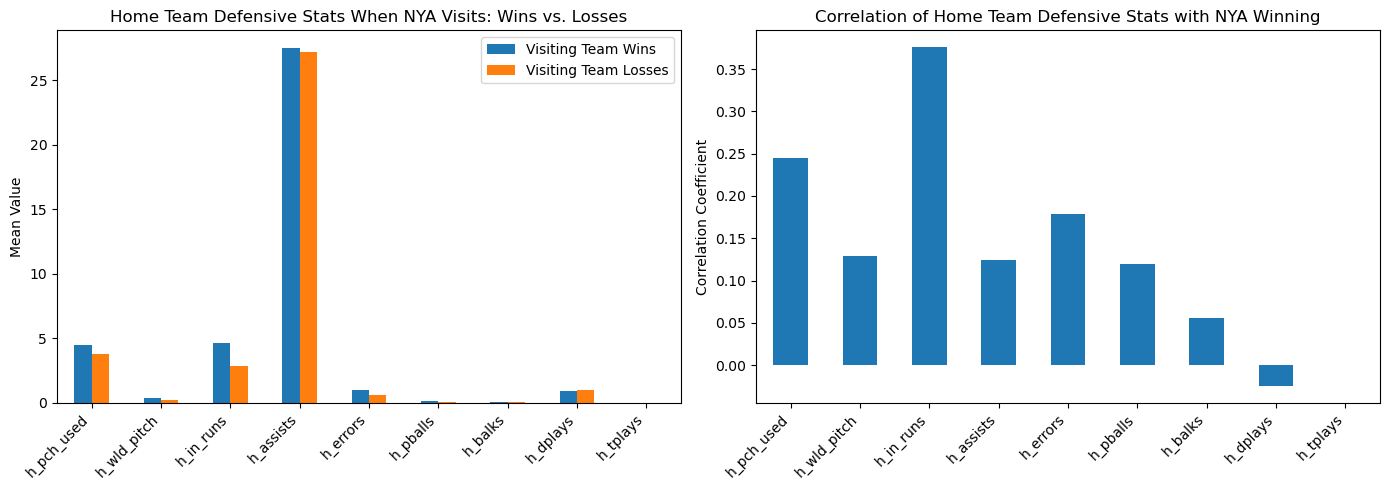

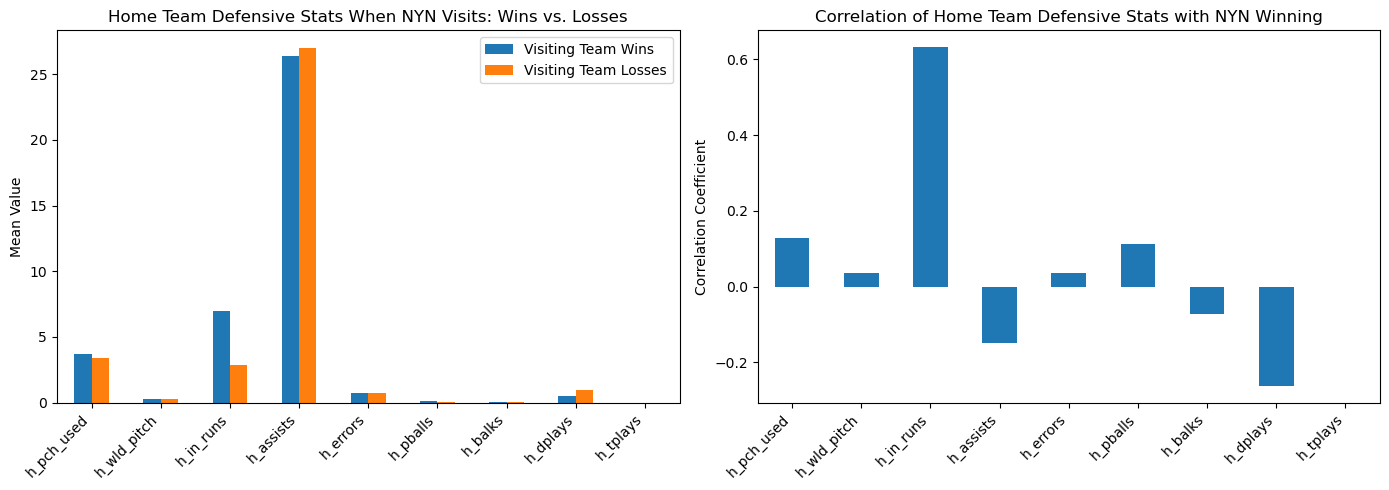

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_games is your DataFrame

# Function to calculate and plot mean home team defensive stats in wins vs. losses
def analyze_home_defensive_performance(df_games, visiting_team_code):
    # Filter games for when the specific visiting team played
    team_visiting_games = df_games[df_games['vteam'] == visiting_team_code]
    
    # Calculate home team stats in visiting team wins and losses
    home_stats_in_visiting_wins = team_visiting_games[team_visiting_games['v_win_val'] == 1]
    home_stats_in_visiting_losses = team_visiting_games[team_visiting_games['v_win_val'] == 0]

    # Define defensive stats for the home team
    defensive_stats = ['h_pch_used', 'h_wld_pitch', 'h_in_runs', 'h_assists', 'h_errors', 'h_pballs', 'h_balks', 'h_dplays', 'h_tplays']
    
    # Calculate the mean home defensive stats in visiting team wins vs. losses
    mean_defensive_stats_wins = home_stats_in_visiting_wins[defensive_stats].mean()
    mean_defensive_stats_losses = home_stats_in_visiting_losses[defensive_stats].mean()

    # Calculate correlation of home defensive stats with visiting team winning
    stats_correlation = team_visiting_games[defensive_stats + ['v_win_val']].corr()['v_win_val']

    # Plotting mean defensive stats comparison
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Mean defensive stats for home team in visiting team wins vs. losses
    mean_stats_df = pd.DataFrame({'Visiting Team Wins': mean_defensive_stats_wins, 'Visiting Team Losses': mean_defensive_stats_losses})
    mean_stats_df.plot(kind='bar', ax=ax[0])
    ax[0].set_title(f'Home Team Defensive Stats When {visiting_team_code} Visits: Wins vs. Losses')
    ax[0].set_ylabel('Mean Value')
    ax[0].set_xticklabels(defensive_stats, rotation=45, ha='right')
    
    # Correlation with visiting team wins
    stats_correlation.drop('v_win_val').plot(kind='bar', ax=ax[1])
    ax[1].set_title(f'Correlation of Home Team Defensive Stats with {visiting_team_code} Winning')
    ax[1].set_ylabel('Correlation Coefficient')
    ax[1].set_xticklabels(defensive_stats, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Analyze home defensive performance when Yankees and Mets are visiting
analyze_home_defensive_performance(df_games, 'NYA')  # Yankees as visiting team
analyze_home_defensive_performance(df_games, 'NYN')  # Mets as visiting team
